In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List

In [2]:
# Define data handling functions
def load_iris() -> Tuple[np.ndarray, np.ndarray]:
    """Load the Iris dataset and return the features and labels"""
    data = pd.read_csv("iris.csv")
    X = data.iloc[:, :-1].values
    y = pd.get_dummies(data.iloc[:, -1]).values
    return X, y


def load_and_normalize_wine_quality() -> Tuple[np.ndarray, np.ndarray]:
    """Load the Wine Quality dataset and normalize the features"""
    data = pd.read_csv("winequality-white.csv", delimiter=';')
    normalized_data = (data.iloc[:, :-1] - data.iloc[:, :-1].min()) / (data.iloc[:, :-1].max() - data.iloc[:, :-1].min())
    y = pd.get_dummies(data.iloc[:, -1]).values
    return normalized_data.values, y


def custom_train_test_split(X: np.ndarray, y: np.ndarray, test_size=0.2, random_state=42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Custom train test split function to split the data into training and testing sets"""
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    test_size = int(X.shape[0] * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

In [3]:
# Define the activation functions
# Define activation functions
def sigmoid(x: np.ndarray) -> np.ndarray:
    """Sigmoid activation function"""
    x = np.clip(x, -500, 500)  # Clip x to prevent overflow
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
    """Derivative of the sigmoid activation function"""
    sig = sigmoid(x)
    return sig * (1 - sig)


def tanh(x: np.ndarray) -> np.ndarray:
    """Hyperbolic tangent activation function"""
    return np.tanh(x)


def tanh_derivative(x: np.ndarray) -> np.ndarray:
    """Derivative of the hyperbolic tangent activation function"""
    return 1 - np.tanh(x)**2

In [4]:
# Define the MLP class
class MLP:
    """Multi-Layer Perceptron class"""
    def __init__(self, layer_sizes, activation_function, learning_rate, momentum, batch_size, epochs):
        """Initialize the Multi-Layer Perceptron
        Args:
        - layer_sizes: List containing the number of neurons in each layer
        - activation_function: Activation function to be used in the hidden layers (sigmoid or tanh)
        - learning_rate: Learning rate for the optimization algorithm
        - momentum: Momentum for the optimization algorithm
        - batch_size: Number of samples to be used in each batch
        - epochs: Number of epochs to train the model
        """
        self.layer_sizes = layer_sizes
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self.train_errors = []
        self.test_errors = []
        self.initialize_weights_biases()

    def initialize_weights_biases(self):
        """Initialize the weights and biases for the network"""
        for i in range(len(self.layer_sizes) - 1):
            limit = np.sqrt(6 / (self.layer_sizes[i] + self.layer_sizes[i + 1]))  # Xavier initialization
            self.weights.append(np.random.uniform(-limit, limit, (self.layer_sizes[i], self.layer_sizes[i + 1])))
            self.biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def forward(self, X: np.ndarray) -> list:
        """Forward pass through the network to compute the activations"""
        activations = [X]
        for i in range(len(self.weights)):
            activation_function = sigmoid if self.activation_function == "sigmoid" else tanh
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = activation_function(z)
            activations.append(a)
        return activations

    def backpropagation(self, X: np.ndarray, y: np.ndarray):
        """Backpropagation algorithm to update the weights and biases"""
        activations = self.forward(X)
        delta = (activations[-1] - y)
        for i in reversed(range(len(self.weights))):
            derivative_function = sigmoid_derivative if self.activation_function == "sigmoid" else tanh_derivative
            delta *= derivative_function(activations[i + 1])
            gradient_w = np.dot(activations[i].T, delta)
            gradient_b = np.sum(delta, axis=0, keepdims=True)
            self.weights[i] -= self.learning_rate * gradient_w
            self.biases[i] -= self.learning_rate * gradient_b
            if i != 0:
                delta = np.dot(delta, self.weights[i].T)

    def compute_loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """Compute the mean squared error loss"""
        return np.mean((y_pred - y_true) ** 2)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict the output for the given input"""
        layer_outputs = self.forward(X)
        return layer_outputs[-1]

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        predictions = self.predict(X)
        accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))
        return accuracy

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        """Train the model using the training data and validate it using the test data"""
        for epoch in range(self.epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(0, len(X_train), self.batch_size):
                X_batch = X_train[i:i + self.batch_size]
                y_batch = y_train[i:i + self.batch_size]
                self.backpropagation(X_batch, y_batch)

            train_pred = self.forward(X_train)[-1]
            test_pred = self.forward(X_test)[-1]
            train_loss = self.compute_loss(train_pred, y_train)
            test_loss = self.compute_loss(test_pred, y_test)
            self.train_errors.append(train_loss)
            self.test_errors.append(test_loss)

            print(f"Epoch {epoch + 1}/{self.epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    def plot_errors(self):
        """Plot the train and test errors vs epochs"""
        plt.plot(self.train_errors, label="Train Error")
        plt.plot(self.test_errors, label="Test Error")
        plt.title("Train and Test Errors vs Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.legend()
        plt.show()

In [5]:
# Get valid inputs from user
def get_inputs_from_user() -> Tuple[List[int], str, float, float, int, int]:
    """This function gets the hyperparameters from the user"""
    # Get the number of layers and based on the number of layers get the number of neurons in each layer
    layer_sizes = []
    while True:
        num_layers = input("Enter the number of hidden layers: ")
        if num_layers and num_layers.isnumeric() and int(num_layers) > 0:
            for i in range(int(num_layers)):
                while True:
                    num_neurons = input(f"Enter the number of neurons in layer {i + 1}: ")
                    if num_neurons and num_neurons.isnumeric() and int(num_neurons) > 0:
                        layer_sizes.append(int(num_neurons))
                        break
                    else:
                        print("Please enter a valid positive number.")
            break
        else:
            print("Please enter a valid positive number.")
    
    # Get the activation function
    activation_function = input("Enter the activation function (sigmoid/tanh): ")
    while activation_function not in ["sigmoid", "tanh"]:
        activation_function = input("Please enter a valid activation function (sigmoid/tanh): ")

    # Get the learning rate
    learning_rate = input("Enter the learning rate: ")
    while not learning_rate.replace(".", "", 1).isdigit():
        learning_rate = input("Please enter a valid learning rate: ")
    
    # Get the momentum
    momentum = input("Enter the momentum: ")
    while not momentum.replace(".", "", 1).isdigit():
        momentum = input("Please enter a valid momentum: ")

    # Get the batch size
    batch_size = input("Enter the batch size: ")
    while not batch_size.isnumeric() or int(batch_size) <= 0:
        batch_size = input("Please enter a valid batch size: ")

    # Get the number of epochs
    epochs = input("Enter the number of epochs: ")
    while not epochs.isnumeric() or int(epochs) <= 0:
        epochs = input("Please enter a valid number of epochs: ")

    return layer_sizes, activation_function, float(learning_rate), float(momentum), int(batch_size), int(epochs)

In [6]:
# Get the hyperparameters from the user
layer_sizes, activation_function, learning_rate, momentum, batch_size, epochs = get_inputs_from_user()
# Adjust the layer sizes based on the input for both datasets
layer_sizes_iris = [4] + layer_sizes + [3]
layer_sizes_wine = [11] + layer_sizes + [7]

In [15]:
# Load and split data for Iris dataset
X_iris, y_iris = load_iris()
print('############ Iris Dataset ############')
print(X_iris.shape, y_iris.shape)
X_train_iris, X_test_iris, y_train_iris, y_test_iris = custom_train_test_split(X_iris, y_iris)
print(X_train_iris.shape, y_train_iris.shape)
print(X_test_iris.shape, y_test_iris.shape)

# Load and split data for Wine Quality dataset
X_wine, y_wine = load_and_normalize_wine_quality()
print('############ Wine Quality Dataset ############')
print(X_wine.shape, y_wine.shape)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = custom_train_test_split(X_wine, y_wine)
print(X_train_wine.shape, y_train_wine.shape)
print(X_test_wine.shape, y_test_wine.shape)

############ Iris Dataset ############
(149, 4) (149, 3)
(120, 4) (120, 3)
(29, 4) (29, 3)
############ Wine Quality Dataset ############
(4898, 11) (4898, 7)
(3919, 11) (3919, 7)
(979, 11) (979, 7)


Epoch 1/500 - Train Loss: 0.2285, Test Loss: 0.2251
Epoch 2/500 - Train Loss: 0.2198, Test Loss: 0.2185
Epoch 3/500 - Train Loss: 0.2154, Test Loss: 0.2142
Epoch 4/500 - Train Loss: 0.2114, Test Loss: 0.2115
Epoch 5/500 - Train Loss: 0.2075, Test Loss: 0.2073
Epoch 6/500 - Train Loss: 0.2038, Test Loss: 0.2035
Epoch 7/500 - Train Loss: 0.2003, Test Loss: 0.2005
Epoch 8/500 - Train Loss: 0.1963, Test Loss: 0.1960
Epoch 9/500 - Train Loss: 0.1926, Test Loss: 0.1923
Epoch 10/500 - Train Loss: 0.1883, Test Loss: 0.1881
Epoch 11/500 - Train Loss: 0.1841, Test Loss: 0.1843
Epoch 12/500 - Train Loss: 0.1801, Test Loss: 0.1806
Epoch 13/500 - Train Loss: 0.1750, Test Loss: 0.1761
Epoch 14/500 - Train Loss: 0.1698, Test Loss: 0.1707
Epoch 15/500 - Train Loss: 0.1646, Test Loss: 0.1655
Epoch 16/500 - Train Loss: 0.1593, Test Loss: 0.1606
Epoch 17/500 - Train Loss: 0.1547, Test Loss: 0.1563
Epoch 18/500 - Train Loss: 0.1497, Test Loss: 0.1513
Epoch 19/500 - Train Loss: 0.1455, Test Loss: 0.1475
Ep

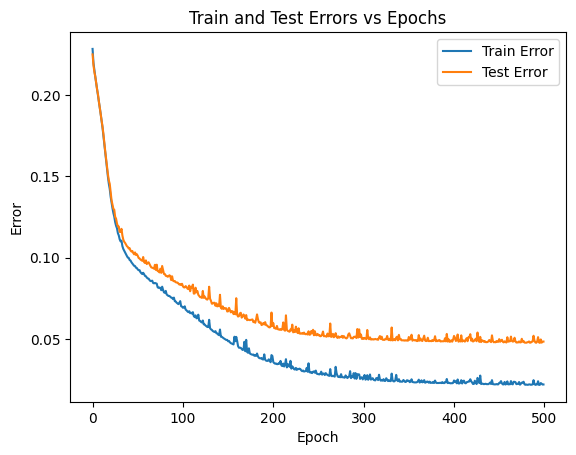

In [8]:
# Create an instance of the MLP class for Iris dataset
mlp_iris = MLP(layer_sizes_iris, activation_function, learning_rate, momentum, batch_size, epochs)
# Train the model for Iris dataset
mlp_iris.fit(X_train_iris, y_train_iris, X_test_iris, y_test_iris)
# Evaluate the model for Iris dataset
train_accuracy_iris = mlp_iris.evaluate(X_train_iris, y_train_iris)
test_accuracy_iris = mlp_iris.evaluate(X_test_iris, y_test_iris)
mlp_iris.plot_errors()

Epoch 1/500 - Train Loss: 0.0985, Test Loss: 0.0985
Epoch 2/500 - Train Loss: 0.0971, Test Loss: 0.0971
Epoch 3/500 - Train Loss: 0.0960, Test Loss: 0.0961
Epoch 4/500 - Train Loss: 0.0952, Test Loss: 0.0951
Epoch 5/500 - Train Loss: 0.0943, Test Loss: 0.0942
Epoch 6/500 - Train Loss: 0.0936, Test Loss: 0.0936
Epoch 7/500 - Train Loss: 0.0930, Test Loss: 0.0930
Epoch 8/500 - Train Loss: 0.0923, Test Loss: 0.0924
Epoch 9/500 - Train Loss: 0.0917, Test Loss: 0.0919
Epoch 10/500 - Train Loss: 0.0913, Test Loss: 0.0916
Epoch 11/500 - Train Loss: 0.0908, Test Loss: 0.0910
Epoch 12/500 - Train Loss: 0.0908, Test Loss: 0.0912
Epoch 13/500 - Train Loss: 0.0901, Test Loss: 0.0903
Epoch 14/500 - Train Loss: 0.0897, Test Loss: 0.0901
Epoch 15/500 - Train Loss: 0.0896, Test Loss: 0.0900
Epoch 16/500 - Train Loss: 0.0894, Test Loss: 0.0899
Epoch 17/500 - Train Loss: 0.0890, Test Loss: 0.0894
Epoch 18/500 - Train Loss: 0.0889, Test Loss: 0.0894
Epoch 19/500 - Train Loss: 0.0886, Test Loss: 0.0892
Ep

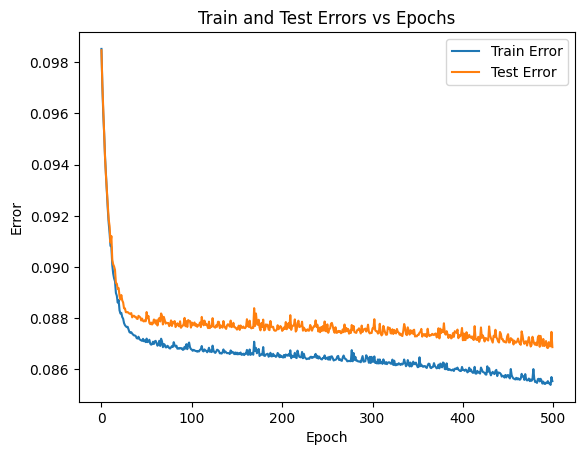

In [9]:
# Create an instance of the MLP class for Wine Quality dataset
mlp_wine = MLP(layer_sizes_wine, activation_function, learning_rate, momentum, batch_size, epochs)
# Train the model for Wine Quality dataset
mlp_wine.fit(X_train_wine, y_train_wine, X_test_wine, y_test_wine)
# Evaluate the model for Wine Quality dataset
train_accuracy_wine = mlp_wine.evaluate(X_train_wine, y_train_wine)
test_accuracy_wine = mlp_wine.evaluate(X_test_wine, y_test_wine)
mlp_wine.plot_errors()

In [10]:
# Print results for Iris dataset
print("Iris Dataset:")
print(f"Train Accuracy: {train_accuracy_iris:.2f}")
print(f"Test Accuracy: {test_accuracy_iris:.2f}")

Iris Dataset:
Train Accuracy: 0.99
Test Accuracy: 0.93


In [11]:
# Print results for Wine Quality dataset
print("\nWine Quality Dataset:")
print(f"Train Accuracy: {train_accuracy_wine:.2f}")
print(f"Test Accuracy: {test_accuracy_wine:.2f}")


Wine Quality Dataset:
Train Accuracy: 0.55
Test Accuracy: 0.52
